In [47]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import copy

import data_utils.pulse as pulse
import data_utils.data_analysis as data_analysis

In [79]:
def shift_pulse(p):
    #shift the pulse so the peak is at thr center of the array
    return np.roll(p,int(len(p)/2)-np.argmax(p))

In [2]:
#Load dataset

In [3]:
filename='datasets/galadriel_dataset_24_09_18_high_res.h5'
df_input,df_time_val,df_time,df_freq_val,df_freq_int = data_analysis.read_dataset(filename)

Input DF
      shot number   order2   order3     order4  goodness
0          163165  34400.0 -23000.0 -5500000.0  0.945039
1          163166  34400.0 -23000.0 -5500000.0  0.862834
2          163167  34400.0 -23000.0 -5500000.0  0.834347
3          163168  34400.0 -23000.0 -5500000.0  0.873099
4          163169  34400.0 -23000.0 -5500000.0  0.851336
...           ...      ...      ...        ...       ...
9498       172664  35400.0  28000.0 -4000000.0  1.031447
9499       172665  35400.0  28000.0 -4000000.0  1.031718
9500       172666  35400.0  28000.0 -4000000.0  1.009015
9501       172667  35400.0  28000.0 -4000000.0  1.199801
9502       172668  35400.0  28000.0 -4000000.0  1.241150

[9503 rows x 5 columns]
----
Time values
0    -104.962227
1     -94.466005
2     -83.969782
3     -73.473559
4     -62.977336
5     -52.481114
6     -41.984891
7     -31.488668
8     -20.992445
9     -10.496223
10      0.000000
11     10.496223
12     20.992445
13     31.488668
14     41.984891
15     52.

In [4]:
df_spec_freq=pd.read_hdf(filename,'df_spec_freq')
df_spec_int=pd.read_hdf(filename,'df_spec_int')
df_spec_phase=pd.read_hdf(filename,'df_spec_phase')

In [5]:
#time in fs (it is the boundary)
def pulse_reconst_old(df_spec_int,df_spec_freq,df_spec_phase,time=100,time_bins=100):
    t = np.linspace(-time,time,time_bins+1)#*1e-15   ## time array, in fs.
    c = 299792458 ## speed of light in m/s
    center_freq = c/800e-9  ## define the center frequency using the known center wavelength of GALADRIEL, 800nm
    
    p_list=[]
    for i in range(0,len(df_spec_freq)):
        intensity=df_spec_int.loc[i].to_numpy()
        frequency=df_spec_freq.loc[i].to_numpy()
        phase=df_spec_phase.loc[i].to_numpy()
        p = pulse.pulse(t,frequency*1e12,intensity,phase,wavelength=False,center=center_freq)
        p_list.append(p.intensity)
    
    return t,pd.DataFrame(p_list)

In [6]:
filename_pulse='datasets/pulse_240918.h5'

In [7]:
#read the data
df_time_50=pd.read_hdf(filename_pulse,'df_time_50',mode='r')
df_pulse_50=pd.read_hdf(filename_pulse,'df_pulse_50')
t_50=df_time_50.to_numpy()

df_time_200=pd.read_hdf(filename_pulse,'df_time_200')
df_pulse_200=pd.read_hdf(filename_pulse,'df_pulse_200')
t_200=df_time_200.to_numpy()

### Drop th shots with bad goodness

In [8]:
df_input_reduced=df_input[df_input['goodness']>1.4]

good_shots_list=df_input_reduced.index.values
#print(good_shots_list)
df_pulse_200_reduced=df_pulse_200.iloc[good_shots_list]
df_spec_freq_reduced=df_spec_freq.iloc[good_shots_list]
df_spec_int_reduced=df_spec_int.iloc[good_shots_list]
df_spec_phase_reduced=df_spec_phase.iloc[good_shots_list]

#reset the index
df_input_reduced.reset_index(inplace=True,drop=True)
df_pulse_200_reduced.reset_index(inplace=True,drop=True)
df_spec_freq_reduced.reset_index(inplace=True,drop=True)
df_spec_int_reduced.reset_index(inplace=True,drop=True)
df_spec_phase_reduced.reset_index(inplace=True,drop=True)

In [9]:
df_input_reduced

,shot number,order2,order3,order4,goodness
0,163182,34400.0,-23000.0,-4900000.0,1.428754
1,163185,34400.0,-23000.0,-4900000.0,1.443683
2,163188,34400.0,-23000.0,-4900000.0,1.418891
3,163230,34400.0,-20000.0,-4900000.0,1.452789
4,163233,34400.0,-20000.0,-4900000.0,1.437333
...,...,...,...,...,...
1963,172388,35400.0,13000.0,-5500000.0,1.456634
1964,172429,35400.0,16000.0,-5500000.0,1.400959
1965,172430,35400.0,16000.0,-5500000.0,1.410054
1966,172431,35400.0,16000.0,-5500000.0,1.417623


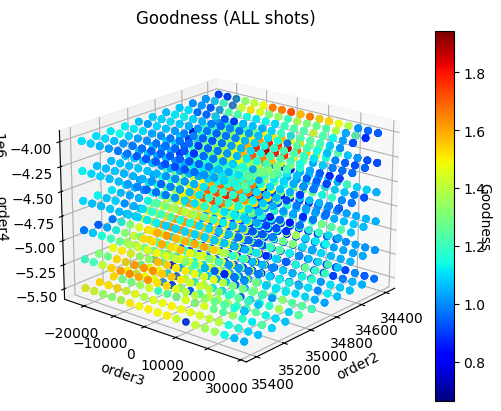

In [10]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plot_3d= ax.scatter(df_input['order2'], df_input['order3'], df_input['order4'],c=df_input['goodness'],cmap='jet')
ax.set_xlabel('order2')
ax.set_ylabel('order3')
ax.set_zlabel('order4')
ax.view_init(elev=20., azim=40)
plt.title('Goodness (ALL shots)')
cbar = plt.colorbar(plot_3d)
cbar.ax.set_ylabel('Goodness', rotation=270)
plt.show()

### Dispersion method

In [48]:
def pulse_dispersion(index_ref,index_final,
                     df_input,df_spec_int,df_spec_freq,df_spec_phase):
    #create a reference pulse with the actual data
    shot_i=index_ref
    time=150
    time_bins=200
    t = np.linspace(-time,time,time_bins+1)   ## time array, in fs.
    c = 299792458 ## speed of light in m/s
    center_freq = c/800e-9  ## define the center frequency using the known center wavelength of GALADRIEL, 800nm
    intensity=df_spec_int.loc[shot_i].to_numpy()
    frequency=df_spec_freq.loc[shot_i].to_numpy()
    phase=df_spec_phase.loc[shot_i].to_numpy()
    p1 = pulse.pulse(t,frequency*1e12,intensity,phase,wavelength=False,center=center_freq)
    p_ref =copy.deepcopy(p1) #pulse.pulse(t,frequency*1e12,intensity,phase,wavelength=False,center=center_freq)


    #get the dispersion values from this reference shot
    o2_ref=df_input.loc[shot_i]['order2']
    o3_ref=df_input.loc[shot_i]['order3']
    o4_ref=df_input.loc[shot_i]['order4']
    #print('Reference values')
    #print('Goodness:',df_input.loc[shot_i]['goodness'])
    #print(o2_ref,o3_ref,o4_ref)

    #desired pulse
    shot_j=index_final
    intensity=df_spec_int.loc[shot_j].to_numpy()
    frequency=df_spec_freq.loc[shot_j].to_numpy()
    phase=df_spec_phase.loc[shot_j].to_numpy()
    #the actual pulse
    p2 = pulse.pulse(t,frequency*1e12,intensity,phase,wavelength=False,center=center_freq)
    o2_final=df_input.loc[shot_j]['order2']
    o3_final=df_input.loc[shot_j]['order3']
    o4_final=df_input.loc[shot_j]['order4']
    #print('Final values')
    #print('Goodness:',df_input.loc[shot_j]['goodness'])
    #print(o2_final,o3_final,o4_final)

    #print(o2_final-o2_ref)
    #print(o3_final-o3_ref)
    #print(o4_final-o4_ref)

    #add dispersion
    p1.dispersion(2,o2_final-o2_ref)
    p1.dispersion(3,o3_final-o3_ref)
    p1.dispersion(4,o4_final-o4_ref)
    return p_ref,p1,p2

In [81]:

def plot_pulses(ref_index, final_index,df_input,df_spec_int,df_spec_freq,df_spec_phase):

    p_ref,p1,p2=pulse_dispersion(ref_index,#ref index
                             final_index, #goal index
                             df_input,df_spec_int,df_spec_freq,df_spec_phase)

    shot_num_ref=df_input['shot number'].iloc[ref_index]
    o2_ref=df_input.loc[ref_index]['order2']
    o3_ref=df_input.loc[ref_index]['order3']
    o4_ref=df_input.loc[ref_index]['order4']
    good_ref=df_input.loc[ref_index]['goodness']

    shot_num_final=df_input['shot number'].iloc[final_index]
    o2_fin=df_input.loc[final_index]['order2']
    o3_fin=df_input.loc[final_index]['order3']
    o4_fin=df_input.loc[final_index]['order4']
    good_fin=df_input.loc[final_index]['goodness']

    
    #shift the pulses so the peak at the center
    p1_s=shift_pulse(p1.intensity)
    p2_s=shift_pulse(p2.intensity)
    error=abs(p2_s-p1_s)
    error=error.sum()/len(p1_s)

    plt.plot(p_ref.intensity,label='Ref shot #'+str(shot_num_ref),linestyle='--')
    plt.plot(p1_s,label='Dispersion method result')
    plt.plot(p2_s,label='Measured shot #'+str(shot_num_final))
    plt.text(145, 0.7, r'$\beta^2_{ref}=$'+str(o2_ref), dict(size=10))
    plt.text(145, 0.60, r'$\beta^3_{ref}=$'+str(o3_ref), dict(size=10))
    plt.text(145, 0.5, r'$\beta^4_{ref}=$'+str(o4_ref), dict(size=10))
    plt.text(145, 0.4, 'goodness={:.3f}'.format(good_ref), dict(size=10))

    plt.text(5, 0.7, r'$\beta^2_{final}=$'+str(o2_fin), dict(size=10))
    plt.text(5, 0.6, r'$\beta^3_{final}=$'+str(o3_fin), dict(size=10))
    plt.text(5, 0.5, r'$\beta^4_{final}=$'+str(o4_fin), dict(size=10))
    plt.text(5, 0.4, 'goodness={:.3f}'.format(good_fin), dict(size=10))

    plt.title('Error from the script result: {:.2f}%'.format(100*error))

    plt.legend()

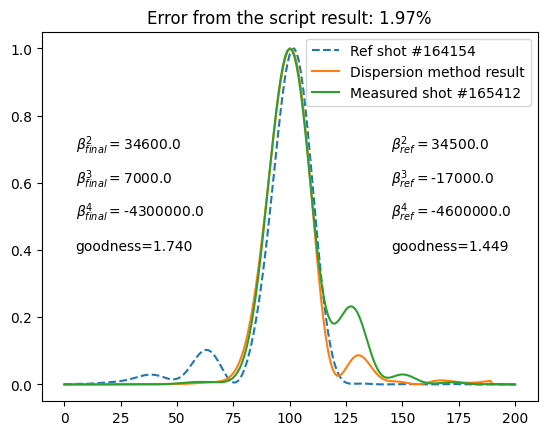

In [82]:
ref_index=150
final_index=350
plot_pulses(ref_index, final_index,
            df_input_reduced,df_spec_int_reduced,df_spec_freq_reduced,df_spec_phase_reduced)

### Around FTL

In [14]:
df_input_reduced[(df_input_reduced['order2']==35000) & (df_input_reduced['order3']==1000)]

,shot number,order2,order3,order4,goodness
1004,168737,35000.0,1000.0,-5500000.0,1.410218
1005,168741,35000.0,1000.0,-5200000.0,1.411794
1006,168742,35000.0,1000.0,-5200000.0,1.447340
1007,168743,35000.0,1000.0,-5200000.0,1.452087
1008,168744,35000.0,1000.0,-5200000.0,1.447157
1009,168745,35000.0,1000.0,-5200000.0,1.451120
1010,168746,35000.0,1000.0,-5200000.0,1.446618
1011,168747,35000.0,1000.0,-5200000.0,1.452087
1012,168748,35000.0,1000.0,-5200000.0,1.461682
1013,168749,35000.0,1000.0,-4900000.0,1.568718


In [15]:
# shot number 168757 to 168764 seems to be closest to FTL pulse (o2=35000, o3=0, and o4=-4.5e6)
# index 1021 to 1028 (included) in df_input_reduced

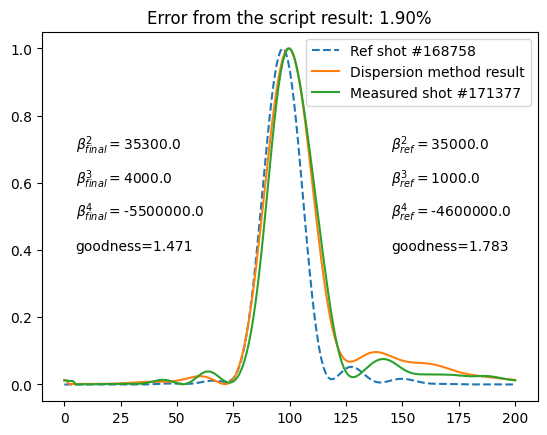

In [83]:
ref_index=1022
final_index=1700
plot_pulses(ref_index, final_index,
            df_input_reduced,df_spec_int_reduced,df_spec_freq_reduced,df_spec_phase_reduced)

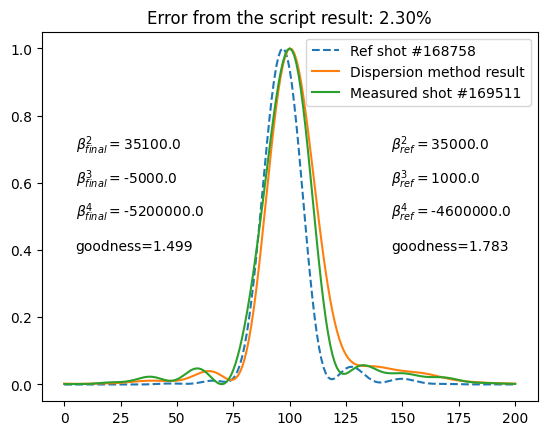

In [84]:
ref_index=1022
final_index=1185
plot_pulses(ref_index, final_index,
            df_input_reduced,df_spec_int_reduced,df_spec_freq_reduced,df_spec_phase_reduced)

In [85]:
#calculate the erro from the script prediction
def get_error(ref_index,final_index,
                     df_input,df_spec_int,df_spec_freq,df_spec_phase):
    p_ref,p1,p2=pulse_dispersion(ref_index,#ref index
                             final_index, #goal index
                             df_input,df_spec_int,df_spec_freq,df_spec_phase)
    #shift the pulses so the peak at the center
    p1_s=shift_pulse(p1.intensity)
    p2_s=shift_pulse(p2.intensity)
    error=abs(p2_s-p1_s)
    error=error.sum()/len(p1_s)
    return error

In [86]:
%%time
ref_index=1022
#final_index=785
error_pred=[]
for i in range(len(df_input_reduced)):
    error_pred.append(get_error(ref_index,i,
                     df_input_reduced,df_spec_int_reduced,df_spec_freq_reduced,df_spec_phase_reduced))

CPU times: user 1min 42s, sys: 457 µs, total: 1min 42s
Wall time: 1min 42s


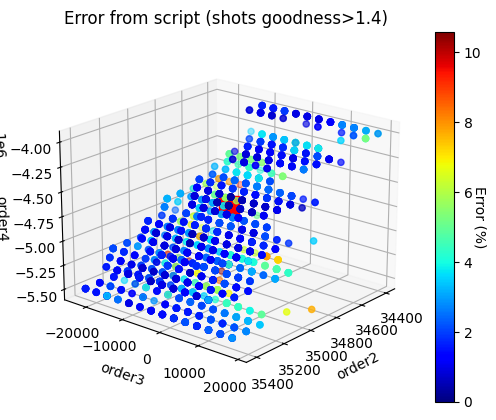

In [87]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plot_3d= ax.scatter(df_input_reduced['order2'], df_input_reduced['order3'], df_input_reduced['order4'],c=100*np.array(error_pred),cmap='jet')
plt.plot(35000,1000,-4600000.0,marker='s',c='red',markersize=15)
ax.set_xlabel('order2')
ax.set_ylabel('order3')
ax.set_zlabel('order4')
ax.view_init(elev=20., azim=40)
plt.title('Error from script (shots goodness>1.4)')
cbar = plt.colorbar(plot_3d)
cbar.ax.set_ylabel('Error (%)', rotation=270)
plt.show()

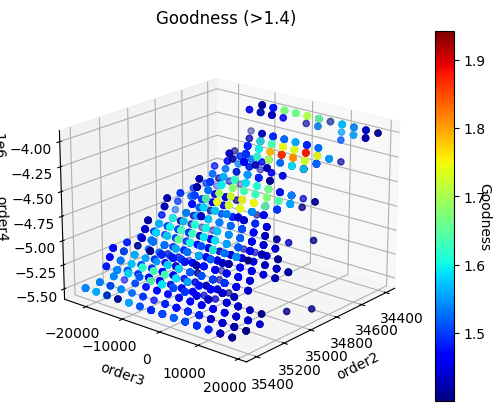

In [88]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plot_3d= ax.scatter(df_input_reduced['order2'], df_input_reduced['order3'], df_input_reduced['order4'],c=df_input_reduced['goodness'],cmap='jet')
ax.set_xlabel('order2')
ax.set_ylabel('order3')
ax.set_zlabel('order4')
ax.view_init(elev=20., azim=40)
plt.title('Goodness (>1.4)')
cbar = plt.colorbar(plot_3d)
cbar.ax.set_ylabel('Goodness', rotation=270)
plt.show()

In [89]:
df_error_pred=100*pd.Series(error_pred)

Text(0, 0.5, 'Num. shots')

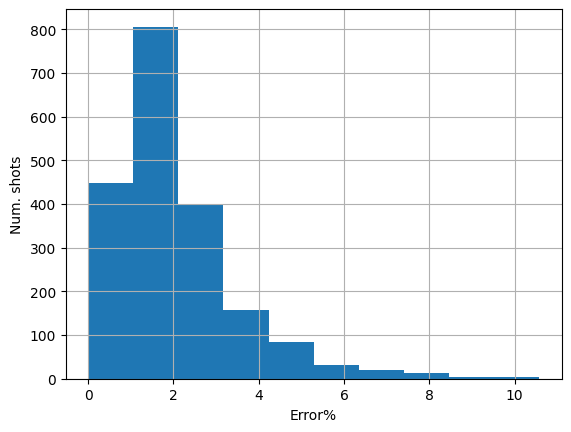

In [90]:
df_error_pred.hist()
plt.xlabel('Error%')
plt.ylabel('Num. shots')

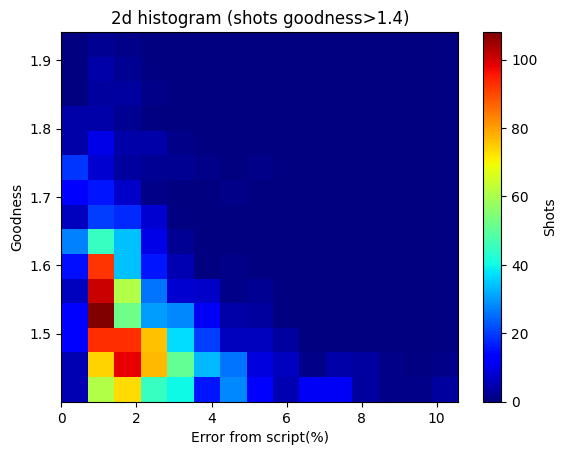

In [91]:
fig, ax = plt.subplots()
plt.hist2d(df_error_pred, df_input_reduced['goodness'],bins=(15, 15),cmap='jet')
ax.set_xlabel('Error from script(%)')
ax.set_ylabel('Goodness')
#ax.set_xlim(-3,3)
#ax.set_ylim(-3,4)
plt.title('2d histogram (shots goodness>1.4)')
#cbar =fig.colorbar(h1, ax=ax)
cbar=plt.colorbar()
cbar.set_label('Shots')
#plt.legend()

In [28]:
##error distribution for the whole dataset

In [92]:
%%time
#ref_index=1022
shot_ptl=168758
ref_index=df_input[df_input['shot number']==shot_ptl].index.values[0]

error_pred_all_shots=[]
for i in range(len(df_input)):
    error_pred_all_shots.append(get_error(ref_index,i,
                     df_input,df_spec_int,df_spec_freq,df_spec_phase))

CPU times: user 8min 33s, sys: 21.1 ms, total: 8min 33s
Wall time: 8min 33s


In [93]:
df_error_pred_all=100*pd.Series(error_pred_all_shots)

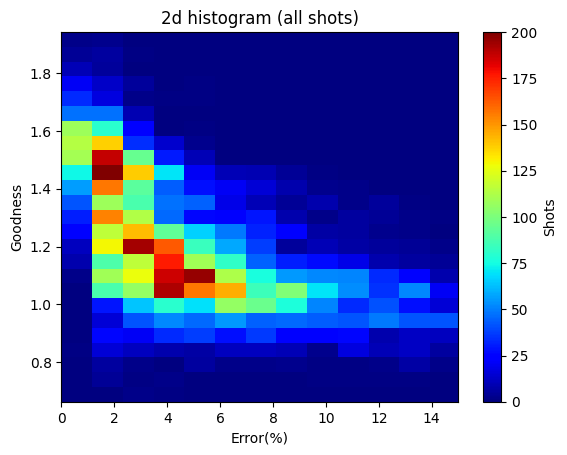

In [95]:
fig, ax = plt.subplots()
plt.hist2d(df_error_pred_all, df_input['goodness'],bins=(25, 25),cmap='jet')
ax.set_xlabel('Error(%)')
ax.set_ylabel('Goodness')
ax.set_xlim(0,15)
#ax.set_ylim(-3,4)
plt.title('2d histogram (all shots)')
#cbar =fig.colorbar(h1, ax=ax)
cbar=plt.colorbar()
cbar.set_label('Shots')
#plt.legend()

### SHIFT PULSe

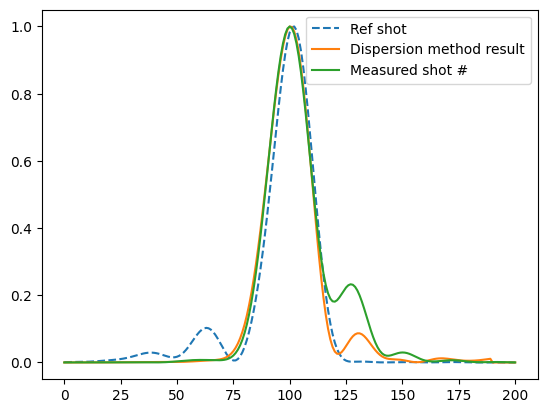

In [80]:
ref_index=150
final_index=350
p_ref,p1,p2=pulse_dispersion(ref_index,#ref index
                             final_index, #goal index
                             df_input_reduced,df_spec_int_reduced,df_spec_freq_reduced,df_spec_phase_reduced)
p_ref=p_ref.intensity
p1=p1.intensity
p2=p2.intensity

#shift the mpeak to center of the array
p1_s=shift_pulse(p1)
p2_s=np.roll(p2,int(len(p2)/2)-np.argmax(p2))

plt.plot(p_ref,label='Ref shot',linestyle='--')
plt.plot(p1_s,label='Dispersion method result')
plt.plot(p2_s,label='Measured shot #')
plt.legend()